In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Data

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob
import numpy as np
import os

Loading and Reading image

In [ ]:
def load_data():
    file_name = []
    file_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/flickr8k/images", "*")

    for filename in sorted(glob.glob(file_path)):
        file_name.append(filename)

    file_name = np.asarray(file_name)
    return file_name

In [ ]:
def read_image(path):
  img = load_img(path, target_size=(240, 240))
  img = img_to_array(img)
  img /= 255.
  return img

In [ ]:
import matplotlib.pyplot as plt

file_name = load_data()

Text(0.5, 1.0, 'A child in a pink dress is climbing up a set of stairs in an entry way .')

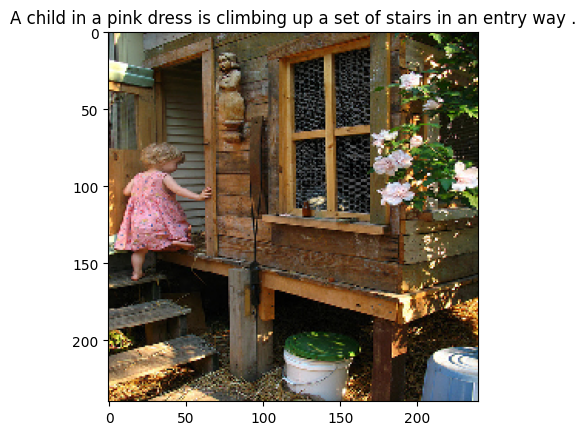

In [ ]:
img = read_image(file_name[0])
plt.imshow(img)
plt.title(data.caption[0])

Text(0.5, 1.0, 'A black and white dog is running in a grassy garden surrounded by a white fence .')

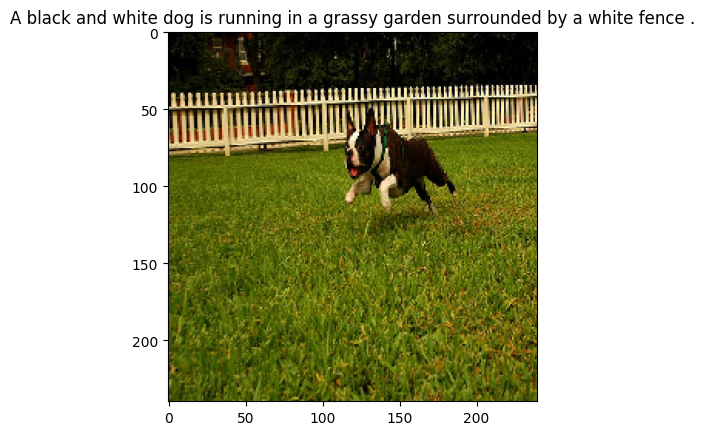

In [ ]:
img = read_image(file_name[6])
plt.imshow(img)
plt.title(data.caption[30])

### Text Preprocessing

In [ ]:
#Preprocessing data
def text_preprocessing(data):
  data["caption"] = data["caption"].apply(lambda x: x.lower())
  data["caption"] = data["caption"].apply(lambda x: x.replace("[^A-Za-z]", ""))
  data["caption"] = data["caption"].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
  data["caption"] = "startseq " + data["caption"] + " endseq"
  data["caption"] = data["caption"].apply(lambda x: x.strip())
  return data

In [ ]:
data = text_preprocessing(data)
data

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
...,...,...
40450,997722733_0cb5439472.jpg,startseq man in pink shirt climbs rock face en...
40451,997722733_0cb5439472.jpg,startseq man is rock climbing high in the air ...
40452,997722733_0cb5439472.jpg,startseq person in red shirt climbing up rock ...
40453,997722733_0cb5439472.jpg,startseq rock climber in red shirt endseq


In [ ]:
imageids = data['image'].unique().tolist()
len(imageids), len(data['caption'])
#shows 5 captions per image

(8091, 40455)

In [ ]:
for i in range(3):
  print(data['caption'][data['image'] == imageids[i]])

0    startseq child in pink dress is climbing up se...
1      startseq girl going into wooden building endseq
2    startseq little girl climbing into wooden play...
3    startseq little girl climbing the stairs to he...
4    startseq little girl in pink dress going into ...
Name: caption, dtype: object
5    startseq black dog and spotted dog are fightin...
6    startseq black dog and tri-colored dog playing...
7    startseq black dog and white dog with brown sp...
8    startseq two dogs of different breeds looking ...
9    startseq two dogs on pavement moving toward ea...
Name: caption, dtype: object
10    startseq little girl covered in paint sits in ...
11    startseq little girl is sitting in front of la...
12    startseq small girl in the grass plays with fi...
13    startseq there is girl with pigtails sitting i...
14    startseq young girl with pigtails painting out...
Name: caption, dtype: object


Making dictionary of captions per image

In [ ]:
# making caption dict
def cap_generator_dict(data):
  caption_dict = {}
  captions = []

  for _, row in data.iterrows():
    image_id = row['image']
    caption = row['caption']
    if image_id not in caption_dict:
      caption_dict[image_id] = []
    caption_dict[image_id].append(caption)

    captions.append(caption)

  return caption_dict, captions

In [ ]:
caption_dict, captions = cap_generator_dict(data)
print(caption_dict[imageids[2]])

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq', 'startseq there is girl with pigtails sitting in front of rainbow painting endseq', 'startseq young girl with pigtails painting outside in the grass endseq']


In [ ]:
image_ids = list(caption_dict.keys())

In [ ]:
import random
random.shuffle(image_ids)

Splitting data in train, test and validation

In [ ]:
train_sp = int(len(image_ids) * 0.9)
test_sp = int(len(image_ids) * 0.95)

train = image_ids[:train_sp]
test = image_ids[train_sp:test_sp]
validation = image_ids[test_sp:]

In [ ]:
len(train), len(test), len(validation)

(7281, 405, 405)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tk = Tokenizer()
captions = data['caption'].tolist()
tk.fit_on_texts(captions)

In [ ]:
vocab_size = len(tk.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

In [ ]:
vocab_size, max_length

(8485, 34)

In [ ]:
trans_seq = tk.texts_to_sequences([captions[0]])
trans_seq, captions[0]

([[1, 42, 3, 89, 171, 6, 118, 50, 392, 11, 393, 3, 27, 5145, 669, 2]],
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq')

In [ ]:
seq_text = tk.sequences_to_texts(trans_seq)
seq_text

['startseq child in pink dress is climbing up set of stairs in an entry way endseq']

### Feature generation from Images

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
features = {}
image_path  = "/content/drive/MyDrive/Colab Notebooks/flickr8k/images/"
cnn_model = Xception(weights="imagenet", include_top=False, pooling="max")
cnn_model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
for image in image_ids:
  img = read_image(os.path.join(image_path, image))
  img = np.expand_dims(img, axis=0)
  feature = cnn_model.predict(img, verbose=0)
  features[image] = feature

In [ ]:
features['1072153132_53d2bb1b60.jpg']

array([[1.4103286 , 0.16270494, 1.1841264 , ..., 0.3269933 , 2.6003447 ,
        1.2988552 ]], dtype=float32)

Saving it in a csv for future use

In [ ]:
import csv

csv_file = "/content/drive/MyDrive/Colab Notebooks/flickr8k/features.csv"
with open(csv_file, "w", newline="") as file:
    writer = csv.writer(file)
    header = ["image", "features"]
    writer.writerow(header)
    for key, values in features.items():
        values = values.tolist()
        row = [key] + values
        writer.writerow(row)

file.close()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/flickr8k/features.csv")

In [ ]:
df.shape

(8091, 2)

Converting the csv into dictionary

In [ ]:
features = {}
for _, row in df.iterrows():
  features[row['image']] = np.array([eval(row['features'])])

In [ ]:
len(features)

8091

In [ ]:
features['1072153132_53d2bb1b60.jpg']

array([[1.41032863, 0.16270494, 1.18412638, ..., 0.32699329, 2.60034466,
        1.29885519]])

###Training our Model

Uses `data_generator` function to generate batches of data to prevent overloading on the machine

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(keys, caption_dict, features, tokenizer, max_length, vocab_size, batch_size):
  x1, x2, y = list(),list(),list()
  n = 0
  while True:
    for key in keys:
      n += 1
      captions = caption_dict[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          x1.append(features[key][0])
          x2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:
        x1 = np.array(x1)
        x2 = np.array(x2)
        y = np.array(y)
        yield [[x1,x2], y]

        x1,x2,y = list(),list(),list()
        n = 0


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Reshape, concatenate, add
import tensorflow as tf
image_input_shape = (2048,)
caption_input_shape = (max_length,)

In [ ]:
image_input = Input(shape=image_input_shape, name="img_input_layer")
caption_input = Input(shape=caption_input_shape, name="cap_input_layer")

img_features = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(image_input)
img_features_shape = Reshape((1, 256), input_shape=(256,))(img_features)

sen_features = Embedding(vocab_size, 256, mask_zero=False)(caption_input)
merged = concatenate([img_features_shape, sen_features], axis=1)
sen_features = LSTM(256)(merged)
x = Dropout(0.5)(sen_features)
x = add([x, img_features])
x = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input_layer (InputLayer)   [(None, 2048)]       0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 256)          524544      ['img_input_layer[0][0]']        
                                                                                                  
 cap_input_layer (InputLayer)   [(None, 34)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_4[0][0]']                
                                                                                            

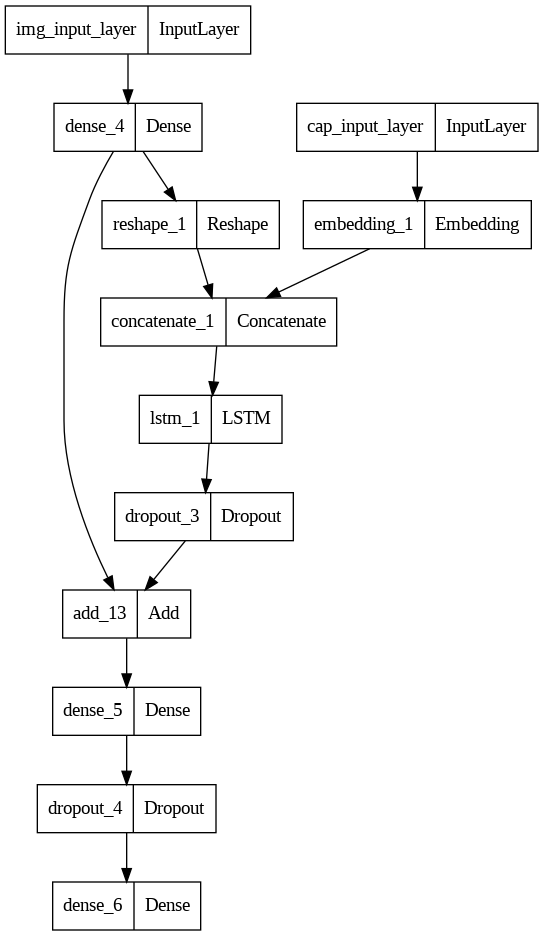

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import gc
from keras import backend as k
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/flickr8k/model-{val_loss:.2f}.h5'
model_checkpoint_callback  = ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_loss",
                            mode="min",save_best_only=True)


In [ ]:
epochs = 30
batch_size = 32
steps_per_epoch = 64 # len(train) // batch_size
validation_steps = 8 # len(validation) // batch_size
train_loss, val_loss =[], []
for i in range(epochs):
  print("Epochs : ", i+1)
  train_generator = data_generator(train, caption_dict, features, tk, max_length, vocab_size, batch_size)
  validation_generator = data_generator(validation, caption_dict, features, tk, max_length, vocab_size, batch_size)

  history = model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,
                      callbacks=[model_checkpoint_callback,ClearMemory()])
  train_loss.append(history.history['loss'][0])
  val_loss.append(history.history['val_loss'][0])

Epochs :  1
64/64 [==============================] - 330s 5s/step - loss: 5.5597 - val_loss: 5.3020
Epochs :  2
64/64 [==============================] - 311s 5s/step - loss: 5.1503 - val_loss: 5.0262
Epochs :  3
64/64 [==============================] - 315s 5s/step - loss: 4.8081 - val_loss: 4.7769
Epochs :  4
64/64 [==============================] - 314s 5s/step - loss: 4.5338 - val_loss: 4.6668
Epochs :  5
64/64 [==============================] - 314s 5s/step - loss: 4.3465 - val_loss: 4.4534
Epochs :  6
64/64 [==============================] - 309s 5s/step - loss: 4.1990 - val_loss: 4.4438
Epochs :  7
64/64 [==============================] - 310s 5s/step - loss: 4.0736 - val_loss: 4.4292
Epochs :  8
64/64 [==============================] - 309s 5s/step - loss: 3.9724 - val_loss: 4.3891
Epochs :  9
64/64 [==============================] - 311s 5s/step - loss: 3.9180 - val_loss: 4.3628
Epochs :  10
64/64 [==============================] - 301s 5s/step - loss: 3.8396 - val_loss: 4.2876

In [ ]:
from tensorflow import keras

Saving the Model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/flickr8k/final_model.h5')

Loading the Model

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/flickr8k/final_model.h5')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input_layer (InputLayer)   [(None, 2048)]       0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 256)          524544      ['img_input_layer[0][0]']        
                                                                                                  
 cap_input_layer (InputLayer)   [(None, 34)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_4[0][0]']                
                                                                                            

### Predicting the caption (Testing)

In [ ]:
def index_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
  in_text = 'startseq' # to start generation
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], max_length)
    y_pred = model.predict([image, sequence])
    y_pred = np.argmax(y_pred)
    word = index_to_word(y_pred, tokenizer)
    if word is None:
      break
    in_text += " " + word
    if word == "endseq":
      break
  return in_text

BLEU score is used to measure the model capability to produce a caption

A BLEU score of 0.5 to 0.9 is considered good, and as seen below, ours is above 0.6 in most cases, hence it is pretty good.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
actual, predicted = list(), list()

for key in tqdm(test):
    captions = caption_dict[key]
    y_pred = predict_caption(model, features[key], tk, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/405 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 1/405 [00:01<11:52,  1.76s/it]

BLEU-1: 0.454545
BLEU-2: 0.213201
1/1 [==============================] - 0s 60ms/step


  0%|          | 2/405 [00:02<08:21,  1.24s/it]

BLEU-1: 0.473684
BLEU-2: 0.236067
1/1 [==============================] - 0s 47ms/step


  1%|          | 3/405 [00:03<07:00,  1.05s/it]

BLEU-1: 0.571046
BLEU-2: 0.302843
1/1 [==============================] - 0s 30ms/step


  1%|          | 4/405 [00:04<06:35,  1.01it/s]

BLEU-1: 0.517294
BLEU-2: 0.261570
1/1 [==============================] - 0s 33ms/step


  1%|          | 5/405 [00:04<05:36,  1.19it/s]

BLEU-1: 0.511621
BLEU-2: 0.233854
1/1 [==============================] - 0s 41ms/step


  1%|▏         | 6/405 [00:05<04:46,  1.39it/s]

BLEU-1: 0.536359
BLEU-2: 0.267060
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 7/405 [00:05<04:07,  1.61it/s]

BLEU-1: 0.559393
BLEU-2: 0.306392
1/1 [==============================] - 0s 30ms/step


  2%|▏         | 8/405 [00:06<04:00,  1.65it/s]

BLEU-1: 0.602790
BLEU-2: 0.359040
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 9/405 [00:06<03:57,  1.67it/s]

BLEU-1: 0.629705
BLEU-2: 0.395679
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 10/405 [00:07<03:44,  1.76it/s]

BLEU-1: 0.639810
BLEU-2: 0.401650
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 11/405 [00:08<03:43,  1.76it/s]

BLEU-1: 0.628865
BLEU-2: 0.381832
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 12/405 [00:08<03:42,  1.77it/s]

BLEU-1: 0.603211
BLEU-2: 0.361025
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 13/405 [00:09<04:03,  1.61it/s]

BLEU-1: 0.595206
BLEU-2: 0.359150
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 14/405 [00:10<04:07,  1.58it/s]

BLEU-1: 0.608217
BLEU-2: 0.372323
1/1 [==============================] - 0s 30ms/step


  4%|▎         | 15/405 [00:10<03:59,  1.63it/s]

BLEU-1: 0.611718
BLEU-2: 0.374681
1/1 [==============================] - 0s 34ms/step


  4%|▍         | 16/405 [00:11<04:07,  1.57it/s]

BLEU-1: 0.615341
BLEU-2: 0.364110
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 17/405 [00:12<04:28,  1.44it/s]

BLEU-1: 0.625761
BLEU-2: 0.368841
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 18/405 [00:12<04:03,  1.59it/s]

BLEU-1: 0.601188
BLEU-2: 0.349276
1/1 [==============================] - 0s 37ms/step


  5%|▍         | 19/405 [00:13<03:58,  1.62it/s]

BLEU-1: 0.604297
BLEU-2: 0.352334
1/1 [==============================] - 0s 34ms/step


  5%|▍         | 20/405 [00:13<04:04,  1.58it/s]

BLEU-1: 0.601972
BLEU-2: 0.360558
1/1 [==============================] - 0s 42ms/step


  5%|▌         | 21/405 [00:14<04:28,  1.43it/s]

BLEU-1: 0.601702
BLEU-2: 0.370179
1/1 [==============================] - 0s 48ms/step


  5%|▌         | 22/405 [00:15<04:32,  1.40it/s]

BLEU-1: 0.610533
BLEU-2: 0.380251
1/1 [==============================] - 0s 44ms/step


  6%|▌         | 23/405 [00:16<05:24,  1.18it/s]

BLEU-1: 0.613761
BLEU-2: 0.373121
1/1 [==============================] - 0s 45ms/step


  6%|▌         | 24/405 [00:17<05:44,  1.11it/s]

BLEU-1: 0.610091
BLEU-2: 0.369550
1/1 [==============================] - 0s 32ms/step


  6%|▌         | 25/405 [00:18<05:37,  1.13it/s]

BLEU-1: 0.605218
BLEU-2: 0.359978
1/1 [==============================] - 0s 30ms/step


  6%|▋         | 26/405 [00:19<05:02,  1.25it/s]

BLEU-1: 0.593515
BLEU-2: 0.350591
1/1 [==============================] - 0s 31ms/step


  7%|▋         | 27/405 [00:19<05:04,  1.24it/s]

BLEU-1: 0.588660
BLEU-2: 0.342707
1/1 [==============================] - 0s 30ms/step


  7%|▋         | 28/405 [00:20<04:30,  1.39it/s]

BLEU-1: 0.585773
BLEU-2: 0.340429
1/1 [==============================] - 0s 32ms/step


  7%|▋         | 29/405 [00:21<04:23,  1.43it/s]

BLEU-1: 0.589922
BLEU-2: 0.346104
1/1 [==============================] - 0s 33ms/step


  7%|▋         | 30/405 [00:21<04:01,  1.55it/s]

BLEU-1: 0.600418
BLEU-2: 0.362362
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 31/405 [00:22<03:54,  1.60it/s]

BLEU-1: 0.601167
BLEU-2: 0.360838
1/1 [==============================] - 0s 30ms/step


  8%|▊         | 32/405 [00:22<03:41,  1.68it/s]

BLEU-1: 0.610846
BLEU-2: 0.378898
1/1 [==============================] - 0s 31ms/step


  8%|▊         | 33/405 [00:23<03:59,  1.55it/s]

BLEU-1: 0.616081
BLEU-2: 0.383914
1/1 [==============================] - 0s 32ms/step


  8%|▊         | 34/405 [00:24<03:53,  1.59it/s]

BLEU-1: 0.615310
BLEU-2: 0.380354
1/1 [==============================] - 0s 33ms/step


  9%|▊         | 35/405 [00:24<04:11,  1.47it/s]

BLEU-1: 0.608608
BLEU-2: 0.375077
1/1 [==============================] - 0s 33ms/step


  9%|▉         | 36/405 [00:25<04:11,  1.47it/s]

BLEU-1: 0.609181
BLEU-2: 0.376302
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.608188


  9%|▉         | 37/405 [00:26<04:29,  1.36it/s]

BLEU-2: 0.382579
1/1 [==============================] - 0s 36ms/step
BLEU-1: 0.604210


  9%|▉         | 38/405 [00:27<04:44,  1.29it/s]

BLEU-2: 0.376255
1/1 [==============================] - 0s 30ms/step


 10%|▉         | 39/405 [00:27<04:34,  1.34it/s]

BLEU-1: 0.604800
BLEU-2: 0.377325
1/1 [==============================] - 0s 42ms/step


 10%|▉         | 40/405 [00:28<04:46,  1.28it/s]

BLEU-1: 0.602601
BLEU-2: 0.374987
1/1 [==============================] - 0s 44ms/step


 10%|█         | 41/405 [00:29<04:53,  1.24it/s]

BLEU-1: 0.608484
BLEU-2: 0.385008
1/1 [==============================] - 0s 43ms/step


 10%|█         | 42/405 [00:30<05:22,  1.12it/s]

BLEU-1: 0.600414
BLEU-2: 0.377312
1/1 [==============================] - 0s 43ms/step


 11%|█         | 43/405 [00:31<05:46,  1.05it/s]

BLEU-1: 0.610641
BLEU-2: 0.389366
1/1 [==============================] - 0s 31ms/step


 11%|█         | 44/405 [00:32<05:51,  1.03it/s]

BLEU-1: 0.612047
BLEU-2: 0.387538
1/1 [==============================] - 0s 30ms/step


 11%|█         | 45/405 [00:33<05:56,  1.01it/s]

BLEU-1: 0.611281
BLEU-2: 0.383562
1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 46/405 [00:34<05:12,  1.15it/s]

BLEU-1: 0.614792
BLEU-2: 0.391230
1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 47/405 [00:35<04:44,  1.26it/s]

BLEU-1: 0.621979
BLEU-2: 0.402258
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.621731


 12%|█▏        | 48/405 [00:35<03:58,  1.50it/s]

BLEU-2: 0.402106
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.620395


 12%|█▏        | 49/405 [00:36<03:59,  1.49it/s]

BLEU-2: 0.397561
1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 50/405 [00:36<04:01,  1.47it/s]

BLEU-1: 0.625746
BLEU-2: 0.406952
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 51/405 [00:37<03:52,  1.52it/s]

BLEU-1: 0.626502
BLEU-2: 0.407022
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 52/405 [00:38<03:46,  1.56it/s]

BLEU-1: 0.632876
BLEU-2: 0.416745
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.630064


 13%|█▎        | 53/405 [00:38<03:52,  1.52it/s]

BLEU-2: 0.411427
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 54/405 [00:39<03:45,  1.56it/s]

BLEU-1: 0.634735
BLEU-2: 0.415827
1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 55/405 [00:40<04:15,  1.37it/s]

BLEU-1: 0.629480
BLEU-2: 0.408895
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 56/405 [00:40<03:50,  1.51it/s]

BLEU-1: 0.631352
BLEU-2: 0.416619
1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 57/405 [00:41<03:54,  1.49it/s]

BLEU-1: 0.631976
BLEU-2: 0.414825
1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 58/405 [00:42<04:03,  1.42it/s]

BLEU-1: 0.635188
BLEU-2: 0.415136
1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 59/405 [00:43<04:16,  1.35it/s]

BLEU-1: 0.638197
BLEU-2: 0.420320
1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 60/405 [00:43<04:02,  1.42it/s]

BLEU-1: 0.642219
BLEU-2: 0.424214
1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 61/405 [00:44<04:27,  1.29it/s]

BLEU-1: 0.645661
BLEU-2: 0.428490
1/1 [==============================] - 0s 91ms/step


 15%|█▌        | 62/405 [00:45<05:05,  1.12it/s]

BLEU-1: 0.646602
BLEU-2: 0.429513
1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 63/405 [00:47<06:24,  1.12s/it]

BLEU-1: 0.642898
BLEU-2: 0.425512
1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 64/405 [00:48<05:59,  1.06s/it]

BLEU-1: 0.642661
BLEU-2: 0.424338
1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 65/405 [00:49<05:48,  1.03s/it]

BLEU-1: 0.643597
BLEU-2: 0.423925
1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 66/405 [00:50<06:11,  1.10s/it]

BLEU-1: 0.643515
BLEU-2: 0.421303
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 67/405 [00:51<05:38,  1.00s/it]

BLEU-1: 0.640624
BLEU-2: 0.417204
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.642043


 17%|█▋        | 68/405 [00:52<04:57,  1.13it/s]

BLEU-2: 0.419206
1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 69/405 [00:52<04:30,  1.24it/s]

BLEU-1: 0.644490
BLEU-2: 0.421850
1/1 [==============================] - 0s 37ms/step
BLEU-1: 0.645826


 17%|█▋        | 70/405 [00:53<04:12,  1.32it/s]

BLEU-2: 0.423742
1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 71/405 [00:53<04:04,  1.37it/s]

BLEU-1: 0.648200
BLEU-2: 0.424902
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.646469


 18%|█▊        | 72/405 [00:54<04:17,  1.30it/s]

BLEU-2: 0.421970
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.646748


 18%|█▊        | 73/405 [00:55<04:10,  1.33it/s]

BLEU-2: 0.423103
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.645593


 18%|█▊        | 74/405 [00:56<04:22,  1.26it/s]

BLEU-2: 0.422699
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.644058


 19%|█▊        | 75/405 [00:57<04:46,  1.15it/s]

BLEU-2: 0.421474
1/1 [==============================] - 0s 48ms/step
BLEU-1: 0.646213
BLEU-2: 0.422610

 19%|█▉        | 76/405 [00:58<04:26,  1.23it/s]


1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 77/405 [00:59<04:51,  1.12it/s]

BLEU-1: 0.645054
BLEU-2: 0.421974
1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 78/405 [01:00<05:00,  1.09it/s]

BLEU-1: 0.649080
BLEU-2: 0.424557
1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 79/405 [01:01<05:06,  1.06it/s]

BLEU-1: 0.652552
BLEU-2: 0.427234
1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 80/405 [01:02<06:26,  1.19s/it]

BLEU-1: 0.652270
BLEU-2: 0.427162
1/1 [==============================] - 0s 67ms/step


 20%|██        | 81/405 [01:05<07:55,  1.47s/it]

BLEU-1: 0.653811
BLEU-2: 0.428559
1/1 [==============================] - 0s 162ms/step


 20%|██        | 82/405 [01:08<10:43,  1.99s/it]

BLEU-1: 0.654849
BLEU-2: 0.428940
1/1 [==============================] - 0s 76ms/step


 20%|██        | 83/405 [01:10<10:37,  1.98s/it]

BLEU-1: 0.657655
BLEU-2: 0.430721
1/1 [==============================] - 0s 67ms/step


 21%|██        | 84/405 [01:11<09:31,  1.78s/it]

BLEU-1: 0.660394
BLEU-2: 0.431326
1/1 [==============================] - 0s 116ms/step


 21%|██        | 85/405 [01:13<09:46,  1.83s/it]

BLEU-1: 0.660469
BLEU-2: 0.432187
1/1 [==============================] - 0s 116ms/step
BLEU-1: 0.659303


 21%|██        | 86/405 [01:16<11:34,  2.18s/it]

BLEU-2: 0.430316
1/1 [==============================] - 0s 72ms/step
BLEU-1: 0.663200


 21%|██▏       | 87/405 [01:17<10:21,  1.96s/it]

BLEU-2: 0.436781
1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 88/405 [01:19<09:16,  1.76s/it]

BLEU-1: 0.663649
BLEU-2: 0.439539
1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 89/405 [01:20<08:35,  1.63s/it]

BLEU-1: 0.662456
BLEU-2: 0.437711
1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 90/405 [01:22<08:55,  1.70s/it]

BLEU-1: 0.660882
BLEU-2: 0.434167
1/1 [==============================] - 0s 48ms/step
BLEU-1: 0.658525


 22%|██▏       | 91/405 [01:23<07:45,  1.48s/it]

BLEU-2: 0.433101
1/1 [==============================] - 0s 53ms/step
BLEU-1: 0.658179


 23%|██▎       | 92/405 [01:24<06:24,  1.23s/it]

BLEU-2: 0.434077
1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 93/405 [01:25<06:21,  1.22s/it]

BLEU-1: 0.661828
BLEU-2: 0.440036
1/1 [==============================] - 0s 54ms/step
BLEU-1: 0.665008


 23%|██▎       | 94/405 [01:26<05:59,  1.15s/it]

BLEU-2: 0.444029
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.663050
BLEU-2: 0.442805

 23%|██▎       | 95/405 [01:27<05:27,  1.06s/it]


1/1 [==============================] - 0s 166ms/step
BLEU-1: 0.660406


 24%|██▎       | 96/405 [01:28<06:23,  1.24s/it]

BLEU-2: 0.440055
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.659320


 24%|██▍       | 97/405 [01:30<06:57,  1.36s/it]

BLEU-2: 0.438428
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.658273


 24%|██▍       | 98/405 [01:31<07:05,  1.39s/it]

BLEU-2: 0.437764
1/1 [==============================] - 0s 50ms/step
BLEU-1: 0.657978


 24%|██▍       | 99/405 [01:32<06:15,  1.23s/it]

BLEU-2: 0.435741
1/1 [==============================] - 0s 49ms/step
BLEU-1: 0.659527

 25%|██▍       | 100/405 [01:33<05:57,  1.17s/it]


BLEU-2: 0.439459
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.659582


 25%|██▍       | 101/405 [01:34<05:22,  1.06s/it]

BLEU-2: 0.438264
1/1 [==============================] - 0s 44ms/step


 25%|██▌       | 102/405 [01:35<05:00,  1.01it/s]

BLEU-1: 0.661098
BLEU-2: 0.439114
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.660444


 25%|██▌       | 103/405 [01:36<04:28,  1.13it/s]

BLEU-2: 0.438192
1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 104/405 [01:36<04:11,  1.20it/s]

BLEU-1: 0.658384
BLEU-2: 0.435413
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.656332


 26%|██▌       | 105/405 [01:37<03:47,  1.32it/s]

BLEU-2: 0.434511
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.651919


 26%|██▌       | 106/405 [01:37<03:41,  1.35it/s]

BLEU-2: 0.430554
1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 107/405 [01:38<03:40,  1.35it/s]

BLEU-1: 0.653435
BLEU-2: 0.430387
1/1 [==============================] - 0s 52ms/step
BLEU-1: 0.653533


 27%|██▋       | 108/405 [01:39<03:29,  1.41it/s]

BLEU-2: 0.430031
1/1 [==============================] - 0s 77ms/step
BLEU-1: 0.654697


 27%|██▋       | 109/405 [01:40<04:19,  1.14it/s]

BLEU-2: 0.430138
1/1 [==============================] - 0s 52ms/step
BLEU-1: 0.657147


 27%|██▋       | 110/405 [01:41<04:22,  1.12it/s]

BLEU-2: 0.432047
1/1 [==============================] - 0s 49ms/step
BLEU-1: 0.659562


 27%|██▋       | 111/405 [01:43<05:51,  1.20s/it]

BLEU-2: 0.432212
1/1 [==============================] - 0s 46ms/step
BLEU-1: 0.655976


 28%|██▊       | 112/405 [01:44<05:31,  1.13s/it]

BLEU-2: 0.429763
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.658683


 28%|██▊       | 113/405 [01:45<05:11,  1.07s/it]

BLEU-2: 0.434052
1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 114/405 [01:46<05:15,  1.09s/it]

BLEU-1: 0.661033
BLEU-2: 0.438503
1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 115/405 [01:47<04:38,  1.04it/s]

BLEU-1: 0.660439
BLEU-2: 0.436847
1/1 [==============================] - 0s 32ms/step


 29%|██▊       | 116/405 [01:47<04:02,  1.19it/s]

BLEU-1: 0.660487
BLEU-2: 0.435655
1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 117/405 [01:48<03:51,  1.24it/s]

BLEU-1: 0.664043
BLEU-2: 0.439241
1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 118/405 [01:49<03:38,  1.31it/s]

BLEU-1: 0.664695
BLEU-2: 0.439430
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.664702


 29%|██▉       | 119/405 [01:49<03:28,  1.37it/s]

BLEU-2: 0.438394
1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 120/405 [01:50<03:22,  1.41it/s]

BLEU-1: 0.665010
BLEU-2: 0.440445
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.664715


 30%|██▉       | 121/405 [01:51<03:15,  1.45it/s]

BLEU-2: 0.439528
1/1 [==============================] - 0s 36ms/step


 30%|███       | 122/405 [01:51<03:34,  1.32it/s]

BLEU-1: 0.662603
BLEU-2: 0.436561
1/1 [==============================] - 0s 39ms/step


 30%|███       | 123/405 [01:53<04:16,  1.10it/s]

BLEU-1: 0.662366
BLEU-2: 0.438200
1/1 [==============================] - 0s 32ms/step


 31%|███       | 124/405 [01:53<03:57,  1.18it/s]

BLEU-1: 0.661202
BLEU-2: 0.437030
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.662136


 31%|███       | 125/405 [01:54<03:49,  1.22it/s]

BLEU-2: 0.436343
1/1 [==============================] - 0s 35ms/step


 31%|███       | 126/405 [01:55<03:34,  1.30it/s]

BLEU-1: 0.660688
BLEU-2: 0.433956
1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 127/405 [01:55<03:02,  1.52it/s]

BLEU-1: 0.662176
BLEU-2: 0.435094
1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 128/405 [01:56<02:54,  1.59it/s]

BLEU-1: 0.659580
BLEU-2: 0.432575
1/1 [==============================] - 0s 46ms/step
BLEU-1: 0.659056


 32%|███▏      | 129/405 [01:57<03:26,  1.34it/s]

BLEU-2: 0.432013
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.658249


 32%|███▏      | 130/405 [01:58<03:29,  1.31it/s]

BLEU-2: 0.430682
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.658010


 32%|███▏      | 131/405 [01:59<03:43,  1.23it/s]

BLEU-2: 0.431530
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.656916


 33%|███▎      | 132/405 [01:59<03:42,  1.23it/s]

BLEU-2: 0.431371
1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 133/405 [02:01<04:22,  1.04it/s]

BLEU-1: 0.656182
BLEU-2: 0.431046
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 134/405 [02:01<03:58,  1.14it/s]

BLEU-1: 0.657921
BLEU-2: 0.431284
1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 135/405 [02:02<03:47,  1.19it/s]

BLEU-1: 0.659634
BLEU-2: 0.434490
1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 136/405 [02:03<03:31,  1.27it/s]

BLEU-1: 0.660227
BLEU-2: 0.435384
1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 137/405 [02:04<03:33,  1.25it/s]

BLEU-1: 0.659739
BLEU-2: 0.435512
1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 138/405 [02:04<03:23,  1.31it/s]

BLEU-1: 0.658182
BLEU-2: 0.433968
1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 139/405 [02:06<04:44,  1.07s/it]

BLEU-1: 0.655142
BLEU-2: 0.432337
1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 140/405 [02:07<04:06,  1.07it/s]

BLEU-1: 0.652043
BLEU-2: 0.429811
1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 141/405 [02:07<03:45,  1.17it/s]

BLEU-1: 0.651876
BLEU-2: 0.430591
1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 142/405 [02:08<03:30,  1.25it/s]

BLEU-1: 0.652488
BLEU-2: 0.430134
1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 143/405 [02:09<03:26,  1.27it/s]

BLEU-1: 0.651815
BLEU-2: 0.430396
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.652174


 36%|███▌      | 144/405 [02:10<03:22,  1.29it/s]

BLEU-2: 0.430167
1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 145/405 [02:10<03:05,  1.40it/s]

BLEU-1: 0.654544
BLEU-2: 0.432616
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.655114


 36%|███▌      | 146/405 [02:11<03:06,  1.39it/s]

BLEU-2: 0.432174
1/1 [==============================] - 0s 45ms/step


 36%|███▋      | 147/405 [02:12<03:55,  1.09it/s]

BLEU-1: 0.657477
BLEU-2: 0.434669
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.657540


 37%|███▋      | 148/405 [02:13<04:09,  1.03it/s]

BLEU-2: 0.433860
1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.658335

 37%|███▋      | 149/405 [02:14<04:09,  1.03it/s]


BLEU-2: 0.435226
1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 150/405 [02:15<03:55,  1.08it/s]

BLEU-1: 0.659376
BLEU-2: 0.435726
1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 151/405 [02:16<04:08,  1.02it/s]

BLEU-1: 0.656517
BLEU-2: 0.432780
1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 152/405 [02:17<03:51,  1.09it/s]

BLEU-1: 0.657065
BLEU-2: 0.433086
1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 153/405 [02:18<03:26,  1.22it/s]

BLEU-1: 0.658317
BLEU-2: 0.434136
1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 154/405 [02:18<03:08,  1.33it/s]

BLEU-1: 0.658116
BLEU-2: 0.434085
1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 155/405 [02:19<03:08,  1.32it/s]

BLEU-1: 0.656263
BLEU-2: 0.431916
1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 156/405 [02:20<03:26,  1.20it/s]

BLEU-1: 0.657293
BLEU-2: 0.433233
1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 157/405 [02:20<03:02,  1.36it/s]

BLEU-1: 0.652152
BLEU-2: 0.429438
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 158/405 [02:21<03:09,  1.31it/s]

BLEU-1: 0.649704
BLEU-2: 0.427116
1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 159/405 [02:22<03:01,  1.35it/s]

BLEU-1: 0.650489
BLEU-2: 0.427244
1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 160/405 [02:23<02:56,  1.39it/s]

BLEU-1: 0.649435
BLEU-2: 0.426480
1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 161/405 [02:23<02:58,  1.36it/s]

BLEU-1: 0.648859
BLEU-2: 0.425563
1/1 [==============================] - 0s 36ms/step


 40%|████      | 162/405 [02:24<03:02,  1.33it/s]

BLEU-1: 0.647610
BLEU-2: 0.423848
1/1 [==============================] - 0s 40ms/step
BLEU-1: 0.647263


 40%|████      | 163/405 [02:25<03:01,  1.33it/s]

BLEU-2: 0.423334
1/1 [==============================] - 0s 54ms/step
BLEU-1: 0.647342


 40%|████      | 164/405 [02:26<03:00,  1.34it/s]

BLEU-2: 0.422557
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.648799


 41%|████      | 165/405 [02:27<03:23,  1.18it/s]

BLEU-2: 0.423492
1/1 [==============================] - 0s 59ms/step


 41%|████      | 166/405 [02:28<03:37,  1.10it/s]

BLEU-1: 0.648451
BLEU-2: 0.422409
1/1 [==============================] - 0s 52ms/step


 41%|████      | 167/405 [02:29<03:42,  1.07it/s]

BLEU-1: 0.648769
BLEU-2: 0.422124
1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 168/405 [02:30<03:29,  1.13it/s]

BLEU-1: 0.649965
BLEU-2: 0.423702
1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 169/405 [02:31<03:31,  1.11it/s]

BLEU-1: 0.650523
BLEU-2: 0.425150
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 170/405 [02:31<03:08,  1.24it/s]

BLEU-1: 0.652556
BLEU-2: 0.428394
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 171/405 [02:32<02:59,  1.30it/s]

BLEU-1: 0.652198
BLEU-2: 0.427879
1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 172/405 [02:32<02:40,  1.45it/s]

BLEU-1: 0.651174
BLEU-2: 0.427309
1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 173/405 [02:33<02:46,  1.39it/s]

BLEU-1: 0.652766
BLEU-2: 0.429083
1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 174/405 [02:34<02:44,  1.41it/s]

BLEU-1: 0.650702
BLEU-2: 0.428125
1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 175/405 [02:34<02:41,  1.42it/s]

BLEU-1: 0.648883
BLEU-2: 0.426317
1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 176/405 [02:35<02:46,  1.37it/s]

BLEU-1: 0.647516
BLEU-2: 0.424794
1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 177/405 [02:36<02:50,  1.34it/s]

BLEU-1: 0.646790
BLEU-2: 0.424029
1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 178/405 [02:37<02:50,  1.33it/s]

BLEU-1: 0.648149
BLEU-2: 0.424355
1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 179/405 [02:38<02:49,  1.33it/s]

BLEU-1: 0.645780
BLEU-2: 0.422523
1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 180/405 [02:38<02:49,  1.32it/s]

BLEU-1: 0.646103
BLEU-2: 0.422913
1/1 [==============================] - 0s 36ms/step
BLEU-1: 0.645799


 45%|████▍     | 181/405 [02:39<02:47,  1.34it/s]

BLEU-2: 0.423108
1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 182/405 [02:40<03:09,  1.18it/s]

BLEU-1: 0.645307
BLEU-2: 0.421785
1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 183/405 [02:41<03:30,  1.05it/s]

BLEU-1: 0.644216
BLEU-2: 0.420278
1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 184/405 [02:42<03:32,  1.04it/s]

BLEU-1: 0.645328
BLEU-2: 0.421723
1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 185/405 [02:43<03:36,  1.02it/s]

BLEU-1: 0.644633
BLEU-2: 0.421017
1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 186/405 [02:44<03:25,  1.06it/s]

BLEU-1: 0.643168
BLEU-2: 0.420307
1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 187/405 [02:45<03:04,  1.18it/s]

BLEU-1: 0.644649
BLEU-2: 0.421995
1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 188/405 [02:46<03:02,  1.19it/s]

BLEU-1: 0.645159
BLEU-2: 0.421165
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.644479


 47%|████▋     | 189/405 [02:46<02:55,  1.23it/s]

BLEU-2: 0.419966
1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 190/405 [02:47<03:11,  1.12it/s]

BLEU-1: 0.644826
BLEU-2: 0.420830
1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.646683


 47%|████▋     | 191/405 [02:48<03:09,  1.13it/s]

BLEU-2: 0.422843
1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 192/405 [02:49<02:57,  1.20it/s]

BLEU-1: 0.648124
BLEU-2: 0.423971
1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 193/405 [02:50<02:54,  1.21it/s]

BLEU-1: 0.648029
BLEU-2: 0.424453
1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 194/405 [02:51<02:46,  1.27it/s]

BLEU-1: 0.646779
BLEU-2: 0.423084
1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 195/405 [02:51<02:46,  1.26it/s]

BLEU-1: 0.647452
BLEU-2: 0.423199
1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 196/405 [02:52<02:44,  1.27it/s]

BLEU-1: 0.647360
BLEU-2: 0.423188
1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 197/405 [02:53<02:38,  1.32it/s]

BLEU-1: 0.647825
BLEU-2: 0.424346
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.647548


 49%|████▉     | 198/405 [02:54<03:05,  1.11it/s]

BLEU-2: 0.424025
1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 199/405 [02:58<05:48,  1.69s/it]

BLEU-1: 0.647636
BLEU-2: 0.424441
1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 200/405 [02:59<05:46,  1.69s/it]

BLEU-1: 0.648719
BLEU-2: 0.425442
1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 201/405 [03:01<05:20,  1.57s/it]

BLEU-1: 0.647566
BLEU-2: 0.424779
1/1 [==============================] - 0s 48ms/step
BLEU-1: 0.646741


 50%|████▉     | 202/405 [03:01<04:34,  1.35s/it]

BLEU-2: 0.424293
1/1 [==============================] - 0s 39ms/step


 50%|█████     | 203/405 [03:02<04:00,  1.19s/it]

BLEU-1: 0.647736
BLEU-2: 0.424645
1/1 [==============================] - 0s 38ms/step


 50%|█████     | 204/405 [03:03<03:48,  1.14s/it]

BLEU-1: 0.646395
BLEU-2: 0.423503
1/1 [==============================] - 0s 93ms/step


 51%|█████     | 205/405 [03:05<04:20,  1.30s/it]

BLEU-1: 0.647971
BLEU-2: 0.425026
1/1 [==============================] - 0s 180ms/step


 51%|█████     | 206/405 [03:08<06:07,  1.85s/it]

BLEU-1: 0.648080
BLEU-2: 0.424471
1/1 [==============================] - 0s 59ms/step


 51%|█████     | 207/405 [03:09<05:27,  1.65s/it]

BLEU-1: 0.649237
BLEU-2: 0.425665
1/1 [==============================] - 0s 50ms/step


 51%|█████▏    | 208/405 [03:10<04:49,  1.47s/it]

BLEU-1: 0.648603
BLEU-2: 0.425479
1/1 [==============================] - 0s 52ms/step
BLEU-1: 0.649219
BLEU-2: 0.425120


 52%|█████▏    | 209/405 [03:11<04:32,  1.39s/it]

1/1 [==============================] - 0s 49ms/step
BLEU-1: 0.649467


 52%|█████▏    | 210/405 [03:12<04:08,  1.28s/it]

BLEU-2: 0.425340
1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 211/405 [03:13<03:45,  1.16s/it]

BLEU-1: 0.650598
BLEU-2: 0.426960
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 212/405 [03:14<03:35,  1.12s/it]

BLEU-1: 0.651386
BLEU-2: 0.427869
1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 213/405 [03:15<03:27,  1.08s/it]

BLEU-1: 0.649571
BLEU-2: 0.426134
1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 214/405 [03:16<03:14,  1.02s/it]

BLEU-1: 0.649134
BLEU-2: 0.425443
1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 215/405 [03:17<03:02,  1.04it/s]

BLEU-1: 0.649216
BLEU-2: 0.424925
1/1 [==============================] - 0s 39ms/step
BLEU-1: 0.649630


 53%|█████▎    | 216/405 [03:18<02:49,  1.11it/s]

BLEU-2: 0.424643
1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 217/405 [03:19<02:45,  1.14it/s]

BLEU-1: 0.648861
BLEU-2: 0.424185
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.648765


 54%|█████▍    | 218/405 [03:19<02:36,  1.19it/s]

BLEU-2: 0.423304
1/1 [==============================] - 0s 35ms/step
BLEU-1: 0.647837


 54%|█████▍    | 219/405 [03:20<02:35,  1.20it/s]

BLEU-2: 0.422037
1/1 [==============================] - 0s 36ms/step
BLEU-1: 0.648249


 54%|█████▍    | 220/405 [03:21<02:29,  1.24it/s]

BLEU-2: 0.422204
1/1 [==============================] - 0s 35ms/step
BLEU-1: 0.648819


 55%|█████▍    | 221/405 [03:22<02:26,  1.26it/s]

BLEU-2: 0.422205
1/1 [==============================] - 0s 36ms/step
BLEU-1: 0.649055


 55%|█████▍    | 222/405 [03:23<02:25,  1.26it/s]

BLEU-2: 0.422856
1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 223/405 [03:24<03:00,  1.01it/s]

BLEU-1: 0.648161
BLEU-2: 0.422133
1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 224/405 [03:25<02:57,  1.02it/s]

BLEU-1: 0.648718
BLEU-2: 0.422143
1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 225/405 [03:26<02:55,  1.03it/s]

BLEU-1: 0.647800
BLEU-2: 0.421355
1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 226/405 [03:27<02:59,  1.00s/it]

BLEU-1: 0.648526
BLEU-2: 0.421306
1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 227/405 [03:28<02:49,  1.05it/s]

BLEU-1: 0.648435
BLEU-2: 0.420462
1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 228/405 [03:29<02:57,  1.00s/it]

BLEU-1: 0.647890
BLEU-2: 0.419967
1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 229/405 [03:30<02:36,  1.12it/s]

BLEU-1: 0.647631
BLEU-2: 0.419616
1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 230/405 [03:31<02:40,  1.09it/s]

BLEU-1: 0.647407
BLEU-2: 0.418924
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.648933
BLEU-2: 0.420603


 57%|█████▋    | 231/405 [03:31<02:34,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 232/405 [03:32<02:28,  1.17it/s]

BLEU-1: 0.647259
BLEU-2: 0.419050
1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 233/405 [03:33<02:05,  1.37it/s]

BLEU-1: 0.646355
BLEU-2: 0.418206
1/1 [==============================] - 0s 37ms/step
BLEU-1: 0.648181
BLEU-2: 0.420071


 58%|█████▊    | 234/405 [03:33<02:09,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 235/405 [03:34<02:01,  1.39it/s]

BLEU-1: 0.649661
BLEU-2: 0.420804
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.649096


 58%|█████▊    | 236/405 [03:35<02:02,  1.38it/s]

BLEU-2: 0.420248
1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 237/405 [03:36<02:14,  1.25it/s]

BLEU-1: 0.650598
BLEU-2: 0.421974
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.649732


 59%|█████▉    | 238/405 [03:36<02:09,  1.29it/s]

BLEU-2: 0.421731
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.649646


 59%|█████▉    | 239/405 [03:37<02:13,  1.25it/s]

BLEU-2: 0.421727
1/1 [==============================] - 0s 60ms/step
BLEU-1: 0.649285


 59%|█████▉    | 240/405 [03:39<02:54,  1.06s/it]

BLEU-2: 0.421594
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.648169


 60%|█████▉    | 241/405 [03:41<03:28,  1.27s/it]

BLEU-2: 0.420707
1/1 [==============================] - 0s 59ms/step
BLEU-1: 0.646867


 60%|█████▉    | 242/405 [03:43<03:51,  1.42s/it]

BLEU-2: 0.419427
1/1 [==============================] - 0s 81ms/step
BLEU-1: 0.646359


 60%|██████    | 243/405 [03:44<04:02,  1.50s/it]

BLEU-2: 0.418581
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.646443


 60%|██████    | 244/405 [03:46<04:33,  1.70s/it]

BLEU-2: 0.418541
1/1 [==============================] - 0s 69ms/step


 60%|██████    | 245/405 [03:48<04:13,  1.59s/it]

BLEU-1: 0.646977
BLEU-2: 0.418255
1/1 [==============================] - 0s 53ms/step
BLEU-1: 0.645394


 61%|██████    | 246/405 [03:49<03:45,  1.42s/it]

BLEU-2: 0.416830
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.645179


 61%|██████    | 247/405 [03:51<04:04,  1.54s/it]

BLEU-2: 0.416616
1/1 [==============================] - 0s 94ms/step


 61%|██████    | 248/405 [03:52<04:10,  1.60s/it]

BLEU-1: 0.643928
BLEU-2: 0.415374
1/1 [==============================] - 0s 97ms/step


 61%|██████▏   | 249/405 [03:55<05:10,  1.99s/it]

BLEU-1: 0.644908
BLEU-2: 0.416410
1/1 [==============================] - 0s 56ms/step
BLEU-1: 0.644396


 62%|██████▏   | 250/405 [03:57<05:04,  1.96s/it]

BLEU-2: 0.415904
1/1 [==============================] - 0s 28ms/step
BLEU-1: 0.645360


 62%|██████▏   | 251/405 [03:58<04:09,  1.62s/it]

BLEU-2: 0.418091
1/1 [==============================] - 0s 35ms/step
BLEU-1: 0.645022


 62%|██████▏   | 252/405 [03:59<03:33,  1.40s/it]

BLEU-2: 0.418390
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.643690


 62%|██████▏   | 253/405 [04:00<03:18,  1.30s/it]

BLEU-2: 0.417019
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.643911


 63%|██████▎   | 254/405 [04:01<02:51,  1.13s/it]

BLEU-2: 0.417603
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.644131


 63%|██████▎   | 255/405 [04:01<02:32,  1.02s/it]

BLEU-2: 0.417806
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.644981


 63%|██████▎   | 256/405 [04:03<02:51,  1.15s/it]

BLEU-2: 0.418899
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.644913


 63%|██████▎   | 257/405 [04:04<02:31,  1.02s/it]

BLEU-2: 0.418540
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.644288


 64%|██████▎   | 258/405 [04:04<02:20,  1.04it/s]

BLEU-2: 0.417811
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.644368


 64%|██████▍   | 259/405 [04:05<02:09,  1.13it/s]

BLEU-2: 0.417784
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.644454


 64%|██████▍   | 260/405 [04:06<02:06,  1.15it/s]

BLEU-2: 0.417751
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.643850


 64%|██████▍   | 261/405 [04:07<02:10,  1.10it/s]

BLEU-2: 0.417017
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.645477


 65%|██████▍   | 262/405 [04:08<02:12,  1.08it/s]

BLEU-2: 0.419040
1/1 [==============================] - 0s 64ms/step


 65%|██████▍   | 263/405 [04:10<03:13,  1.36s/it]

BLEU-1: 0.644046
BLEU-2: 0.417770
1/1 [==============================] - 0s 57ms/step
BLEU-1: 0.642909


 65%|██████▌   | 264/405 [04:12<03:41,  1.57s/it]

BLEU-2: 0.416684
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.642998


 65%|██████▌   | 265/405 [04:13<03:09,  1.35s/it]

BLEU-2: 0.417016
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.642842


 66%|██████▌   | 266/405 [04:14<03:04,  1.33s/it]

BLEU-2: 0.416412
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.644025


 66%|██████▌   | 267/405 [04:15<02:42,  1.18s/it]

BLEU-2: 0.418258
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.644930


 66%|██████▌   | 268/405 [04:16<02:26,  1.07s/it]

BLEU-2: 0.419914
1/1 [==============================] - 0s 28ms/step
BLEU-1: 0.644866


 66%|██████▋   | 269/405 [04:17<02:12,  1.03it/s]

BLEU-2: 0.419215
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.646170


 67%|██████▋   | 270/405 [04:18<02:04,  1.08it/s]

BLEU-2: 0.421340
1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 271/405 [04:19<02:14,  1.00s/it]

BLEU-1: 0.644759
BLEU-2: 0.420022
1/1 [==============================] - 0s 50ms/step
BLEU-1: 0.644695


 67%|██████▋   | 272/405 [04:20<02:38,  1.19s/it]

BLEU-2: 0.419681
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.643565


 67%|██████▋   | 273/405 [04:21<02:25,  1.10s/it]

BLEU-2: 0.418550
1/1 [==============================] - 0s 39ms/step
BLEU-1: 0.644167


 68%|██████▊   | 274/405 [04:22<02:07,  1.03it/s]

BLEU-2: 0.418176
1/1 [==============================] - 0s 41ms/step
BLEU-1: 0.643990


 68%|██████▊   | 275/405 [04:23<02:15,  1.04s/it]

BLEU-2: 0.417965
1/1 [==============================] - 0s 41ms/step
BLEU-1: 0.643673


 68%|██████▊   | 276/405 [04:24<02:21,  1.10s/it]

BLEU-2: 0.417803
1/1 [==============================] - 0s 56ms/step
BLEU-1: 0.643746


 68%|██████▊   | 277/405 [04:25<02:13,  1.04s/it]

BLEU-2: 0.418477
1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.642899


 69%|██████▊   | 278/405 [04:26<02:16,  1.08s/it]

BLEU-2: 0.417881
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.644033


 69%|██████▉   | 279/405 [04:28<02:17,  1.09s/it]

BLEU-2: 0.418275
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.643606


 69%|██████▉   | 280/405 [04:29<02:13,  1.06s/it]

BLEU-2: 0.417208
1/1 [==============================] - 0s 35ms/step
BLEU-1: 0.643291


 69%|██████▉   | 281/405 [04:29<01:59,  1.04it/s]

BLEU-2: 0.416719
1/1 [==============================] - 0s 46ms/step
BLEU-1: 0.643644


 70%|██████▉   | 282/405 [04:31<02:06,  1.02s/it]

BLEU-2: 0.416613
1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 283/405 [04:34<03:33,  1.75s/it]

BLEU-1: 0.641965
BLEU-2: 0.414939
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.642826


 70%|███████   | 284/405 [04:35<03:11,  1.59s/it]

BLEU-2: 0.416516
1/1 [==============================] - 0s 30ms/step


 70%|███████   | 285/405 [04:37<03:11,  1.60s/it]

BLEU-1: 0.643680
BLEU-2: 0.418080
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.643239


 71%|███████   | 286/405 [04:38<02:49,  1.42s/it]

BLEU-2: 0.417302
1/1 [==============================] - 0s 50ms/step
BLEU-1: 0.642968


 71%|███████   | 287/405 [04:40<03:00,  1.53s/it]

BLEU-2: 0.416880
1/1 [==============================] - 0s 49ms/step
BLEU-1: 0.643681


 71%|███████   | 288/405 [04:41<02:48,  1.44s/it]

BLEU-2: 0.417470
1/1 [==============================] - 0s 57ms/step
BLEU-1: 0.642999


 71%|███████▏  | 289/405 [04:43<02:59,  1.55s/it]

BLEU-2: 0.416864
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.642697


 72%|███████▏  | 290/405 [04:44<02:46,  1.45s/it]

BLEU-2: 0.416721
1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 291/405 [04:46<03:17,  1.73s/it]

BLEU-1: 0.641776
BLEU-2: 0.415962
1/1 [==============================] - 0s 54ms/step
BLEU-1: 0.640031


 72%|███████▏  | 292/405 [04:48<03:33,  1.89s/it]

BLEU-2: 0.414181
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.640983


 72%|███████▏  | 293/405 [04:49<02:59,  1.61s/it]

BLEU-2: 0.415577
1/1 [==============================] - 0s 70ms/step
BLEU-1: 0.641549


 73%|███████▎  | 294/405 [04:50<02:34,  1.39s/it]

BLEU-2: 0.416209
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.640888


 73%|███████▎  | 295/405 [04:52<02:27,  1.34s/it]

BLEU-2: 0.415944
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.641350


 73%|███████▎  | 296/405 [04:53<02:19,  1.28s/it]

BLEU-2: 0.415711
1/1 [==============================] - 0s 48ms/step
BLEU-1: 0.641804


 73%|███████▎  | 297/405 [04:54<02:16,  1.26s/it]

BLEU-2: 0.416130
1/1 [==============================] - 0s 88ms/step


 74%|███████▎  | 298/405 [04:55<02:22,  1.33s/it]

BLEU-1: 0.641013
BLEU-2: 0.415277
1/1 [==============================] - 0s 223ms/step
BLEU-1: 0.640727


 74%|███████▍  | 299/405 [04:58<02:55,  1.66s/it]

BLEU-2: 0.415145
1/1 [==============================] - 0s 113ms/step
BLEU-1: 0.641442


 74%|███████▍  | 300/405 [05:01<03:41,  2.11s/it]

BLEU-2: 0.416110
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.638772


 74%|███████▍  | 301/405 [05:07<05:45,  3.33s/it]

BLEU-2: 0.414053
1/1 [==============================] - 0s 88ms/step


 75%|███████▍  | 302/405 [05:11<05:55,  3.45s/it]

BLEU-1: 0.638039
BLEU-2: 0.413287
1/1 [==============================] - 0s 70ms/step
BLEU-1: 0.638853


 75%|███████▍  | 303/405 [05:13<05:14,  3.09s/it]

BLEU-2: 0.414445
1/1 [==============================] - 0s 57ms/step
BLEU-1: 0.639663


 75%|███████▌  | 304/405 [05:15<04:42,  2.80s/it]

BLEU-2: 0.415283
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.640211


 75%|███████▌  | 305/405 [05:16<03:53,  2.34s/it]

BLEU-2: 0.415261
1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 306/405 [05:18<03:31,  2.14s/it]

BLEU-1: 0.639608
BLEU-2: 0.414776
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.639695


 76%|███████▌  | 307/405 [05:20<03:09,  1.93s/it]

BLEU-2: 0.414757
1/1 [==============================] - 0s 68ms/step
BLEU-1: 0.640235


 76%|███████▌  | 308/405 [05:21<02:45,  1.71s/it]

BLEU-2: 0.415359
1/1 [==============================] - 0s 70ms/step
BLEU-1: 0.640320


 76%|███████▋  | 309/405 [05:22<02:38,  1.65s/it]

BLEU-2: 0.415646
1/1 [==============================] - 0s 127ms/step
BLEU-1: 0.639702


 77%|███████▋  | 310/405 [05:26<03:28,  2.19s/it]

BLEU-2: 0.414769
1/1 [==============================] - 0s 116ms/step
BLEU-1: 0.638606


 77%|███████▋  | 311/405 [05:28<03:38,  2.32s/it]

BLEU-2: 0.413839
1/1 [==============================] - 0s 90ms/step


 77%|███████▋  | 312/405 [05:30<03:06,  2.01s/it]

BLEU-1: 0.638113
BLEU-2: 0.413578
1/1 [==============================] - 0s 113ms/step
BLEU-1: 0.638679


 77%|███████▋  | 313/405 [05:31<02:58,  1.94s/it]

BLEU-2: 0.413637
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.637822


 78%|███████▊  | 314/405 [05:33<02:47,  1.85s/it]

BLEU-2: 0.412857
1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 315/405 [05:38<04:07,  2.75s/it]

BLEU-1: 0.636960
BLEU-2: 0.411282
1/1 [==============================] - 0s 87ms/step
BLEU-1: 0.636706
BLEU-2: 0.410870

 78%|███████▊  | 316/405 [05:40<03:36,  2.44s/it]


1/1 [==============================] - 0s 111ms/step
BLEU-1: 0.635452


 78%|███████▊  | 317/405 [05:43<03:50,  2.62s/it]

BLEU-2: 0.409600
1/1 [==============================] - 0s 76ms/step
BLEU-1: 0.636797


 79%|███████▊  | 318/405 [05:45<03:33,  2.45s/it]

BLEU-2: 0.411266
1/1 [==============================] - 0s 94ms/step
BLEU-1: 0.637136


 79%|███████▉  | 319/405 [05:47<03:15,  2.27s/it]

BLEU-2: 0.412394
1/1 [==============================] - 0s 54ms/step
BLEU-1: 0.636761


 79%|███████▉  | 320/405 [05:49<03:10,  2.24s/it]

BLEU-2: 0.411720
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.636173


 79%|███████▉  | 321/405 [05:50<02:37,  1.87s/it]

BLEU-2: 0.411196
1/1 [==============================] - 0s 56ms/step
BLEU-1: 0.635650


 80%|███████▉  | 322/405 [05:51<02:29,  1.80s/it]

BLEU-2: 0.411117
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.635865


 80%|███████▉  | 323/405 [05:52<02:07,  1.55s/it]

BLEU-2: 0.411088
1/1 [==============================] - 0s 51ms/step
BLEU-1: 0.636753


 80%|████████  | 324/405 [05:54<02:01,  1.50s/it]

BLEU-2: 0.411844
1/1 [==============================] - 0s 52ms/step
BLEU-1: 0.637756


 80%|████████  | 325/405 [05:55<01:59,  1.50s/it]

BLEU-2: 0.412847
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.637417


 80%|████████  | 326/405 [05:57<02:04,  1.57s/it]

BLEU-2: 0.412253
1/1 [==============================] - 0s 41ms/step


 81%|████████  | 327/405 [05:59<02:07,  1.63s/it]

BLEU-1: 0.637717
BLEU-2: 0.412100
1/1 [==============================] - 0s 94ms/step
BLEU-1: 0.638012


 81%|████████  | 328/405 [06:00<02:07,  1.65s/it]

BLEU-2: 0.412827
1/1 [==============================] - 0s 44ms/step


 81%|████████  | 329/405 [06:03<02:14,  1.77s/it]

BLEU-1: 0.636833
BLEU-2: 0.411668
1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 330/405 [06:05<02:20,  1.87s/it]

BLEU-1: 0.636652
BLEU-2: 0.411965
1/1 [==============================] - 0s 70ms/step
BLEU-1: 0.636324


 82%|████████▏ | 331/405 [06:07<02:22,  1.93s/it]

BLEU-2: 0.411101
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.636975


 82%|████████▏ | 332/405 [06:08<02:09,  1.77s/it]

BLEU-2: 0.412266
1/1 [==============================] - 0s 54ms/step
BLEU-1: 0.636737


 82%|████████▏ | 333/405 [06:09<01:57,  1.64s/it]

BLEU-2: 0.411869
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.636173


 82%|████████▏ | 334/405 [06:10<01:41,  1.43s/it]

BLEU-2: 0.411103
1/1 [==============================] - 0s 46ms/step
BLEU-1: 0.635732


 83%|████████▎ | 335/405 [06:12<01:42,  1.46s/it]

BLEU-2: 0.411139
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.636350


 83%|████████▎ | 336/405 [06:13<01:35,  1.38s/it]

BLEU-2: 0.411650
1/1 [==============================] - 0s 49ms/step
BLEU-1: 0.635387


 83%|████████▎ | 337/405 [06:15<01:36,  1.42s/it]

BLEU-2: 0.410596
1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.634952


 83%|████████▎ | 338/405 [06:16<01:33,  1.40s/it]

BLEU-2: 0.410355
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.634810


 84%|████████▎ | 339/405 [06:17<01:19,  1.20s/it]

BLEU-2: 0.410145
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.634698


 84%|████████▍ | 340/405 [06:18<01:12,  1.11s/it]

BLEU-2: 0.410010
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.634789


 84%|████████▍ | 341/405 [06:18<01:06,  1.04s/it]

BLEU-2: 0.410282
1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 342/405 [06:19<01:02,  1.00it/s]

BLEU-1: 0.635919
BLEU-2: 0.411020
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.637359


 85%|████████▍ | 343/405 [06:20<00:59,  1.04it/s]

BLEU-2: 0.413227
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.636923


 85%|████████▍ | 344/405 [06:21<00:53,  1.13it/s]

BLEU-2: 0.413269
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.637150


 85%|████████▌ | 345/405 [06:22<01:00,  1.01s/it]

BLEU-2: 0.413547
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.636094


 85%|████████▌ | 346/405 [06:23<00:57,  1.03it/s]

BLEU-2: 0.412558
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.635577


 86%|████████▌ | 347/405 [06:24<00:51,  1.12it/s]

BLEU-2: 0.412174
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.635383


 86%|████████▌ | 348/405 [06:25<00:54,  1.04it/s]

BLEU-2: 0.411589
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.635472


 86%|████████▌ | 349/405 [06:26<00:54,  1.04it/s]

BLEU-2: 0.411843
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.635333


 86%|████████▋ | 350/405 [06:27<00:53,  1.03it/s]

BLEU-2: 0.411637
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.635728


 87%|████████▋ | 351/405 [06:28<00:56,  1.04s/it]

BLEU-2: 0.411996
1/1 [==============================] - 0s 41ms/step
BLEU-1: 0.635788


 87%|████████▋ | 352/405 [06:29<00:56,  1.06s/it]

BLEU-2: 0.411645
1/1 [==============================] - 0s 50ms/step
BLEU-1: 0.635790


 87%|████████▋ | 353/405 [06:31<01:01,  1.19s/it]

BLEU-2: 0.410937
1/1 [==============================] - 0s 36ms/step
BLEU-1: 0.635374


 87%|████████▋ | 354/405 [06:32<00:57,  1.12s/it]

BLEU-2: 0.410175
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.635766


 88%|████████▊ | 355/405 [06:33<00:53,  1.07s/it]

BLEU-2: 0.410528
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.635243


 88%|████████▊ | 356/405 [06:34<00:49,  1.01s/it]

BLEU-2: 0.410063
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.635025


 88%|████████▊ | 357/405 [06:34<00:46,  1.03it/s]

BLEU-2: 0.409962
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.634808


 88%|████████▊ | 358/405 [06:35<00:43,  1.07it/s]

BLEU-2: 0.409342
1/1 [==============================] - 0s 35ms/step
BLEU-1: 0.634399


 89%|████████▊ | 359/405 [06:36<00:40,  1.12it/s]

BLEU-2: 0.409388
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.634103


 89%|████████▉ | 360/405 [06:37<00:41,  1.10it/s]

BLEU-2: 0.408871
1/1 [==============================] - 0s 29ms/step
BLEU-1: 0.633481


 89%|████████▉ | 361/405 [06:38<00:38,  1.15it/s]

BLEU-2: 0.408196
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.633161


 89%|████████▉ | 362/405 [06:39<00:36,  1.18it/s]

BLEU-2: 0.407874
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.632955


 90%|████████▉ | 363/405 [06:40<00:37,  1.13it/s]

BLEU-2: 0.407514
1/1 [==============================] - 0s 53ms/step
BLEU-1: 0.633045


 90%|████████▉ | 364/405 [06:41<00:41,  1.02s/it]

BLEU-2: 0.407518
1/1 [==============================] - 0s 92ms/step


 90%|█████████ | 365/405 [06:43<00:52,  1.31s/it]

BLEU-1: 0.632946
BLEU-2: 0.407400
1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 366/405 [06:46<01:13,  1.88s/it]

BLEU-1: 0.633656
BLEU-2: 0.408430
1/1 [==============================] - 0s 45ms/step
BLEU-1: 0.633529


 91%|█████████ | 367/405 [06:48<01:09,  1.82s/it]

BLEU-2: 0.408234
1/1 [==============================] - 0s 129ms/step
BLEU-1: 0.632040


 91%|█████████ | 368/405 [06:55<02:10,  3.54s/it]

BLEU-2: 0.406882
1/1 [==============================] - 0s 129ms/step
BLEU-1: 0.631360


 91%|█████████ | 369/405 [06:58<01:56,  3.23s/it]

BLEU-2: 0.406069
1/1 [==============================] - 0s 55ms/step
BLEU-1: 0.631744


 91%|█████████▏| 370/405 [07:00<01:41,  2.89s/it]

BLEU-2: 0.406686
1/1 [==============================] - 0s 48ms/step
BLEU-1: 0.631835


 92%|█████████▏| 371/405 [07:01<01:21,  2.40s/it]

BLEU-2: 0.406945
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.631820


 92%|█████████▏| 372/405 [07:02<01:05,  1.98s/it]

BLEU-2: 0.406981
1/1 [==============================] - 0s 106ms/step


 92%|█████████▏| 373/405 [07:04<01:02,  1.97s/it]

BLEU-1: 0.632490
BLEU-2: 0.408180
1/1 [==============================] - 0s 59ms/step
BLEU-1: 0.632211


 92%|█████████▏| 374/405 [07:05<00:54,  1.77s/it]

BLEU-2: 0.407701
1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 375/405 [07:07<00:47,  1.59s/it]

BLEU-1: 0.631618
BLEU-2: 0.407049
1/1 [==============================] - 0s 32ms/step
BLEU-1: 0.631815


 93%|█████████▎| 376/405 [07:08<00:47,  1.64s/it]

BLEU-2: 0.407272
1/1 [==============================] - 0s 112ms/step
BLEU-1: 0.631724


 93%|█████████▎| 377/405 [07:10<00:49,  1.76s/it]

BLEU-2: 0.407402
1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.631919


 93%|█████████▎| 378/405 [07:12<00:47,  1.74s/it]

BLEU-2: 0.407622
1/1 [==============================] - 0s 72ms/step
BLEU-1: 0.631904


 94%|█████████▎| 379/405 [07:14<00:48,  1.87s/it]

BLEU-2: 0.407898
1/1 [==============================] - 0s 99ms/step
BLEU-1: 0.632770


 94%|█████████▍| 380/405 [07:18<01:00,  2.41s/it]

BLEU-2: 0.409500
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.632856


 94%|█████████▍| 381/405 [07:19<00:46,  1.95s/it]

BLEU-2: 0.409989
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.632659


 94%|█████████▍| 382/405 [07:20<00:36,  1.61s/it]

BLEU-2: 0.409657
1/1 [==============================] - 0s 40ms/step
BLEU-1: 0.632211


 95%|█████████▍| 383/405 [07:21<00:32,  1.47s/it]

BLEU-2: 0.409044
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.632551


 95%|█████████▍| 384/405 [07:21<00:26,  1.24s/it]

BLEU-2: 0.409312
1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 385/405 [07:22<00:21,  1.08s/it]

BLEU-1: 0.632992
BLEU-2: 0.409555
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.632443


 95%|█████████▌| 386/405 [07:23<00:20,  1.08s/it]

BLEU-2: 0.409219
1/1 [==============================] - 0s 38ms/step
BLEU-1: 0.631795


 96%|█████████▌| 387/405 [07:24<00:19,  1.09s/it]

BLEU-2: 0.408427
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.631328
BLEU-2: 0.407746


 96%|█████████▌| 388/405 [07:26<00:19,  1.13s/it]

1/1 [==============================] - 0s 44ms/step
BLEU-1: 0.631693


 96%|█████████▌| 389/405 [07:27<00:17,  1.10s/it]

BLEU-2: 0.408079
1/1 [==============================] - 0s 50ms/step
BLEU-1: 0.632057


 96%|█████████▋| 390/405 [07:28<00:17,  1.16s/it]

BLEU-2: 0.408651
1/1 [==============================] - 0s 43ms/step
BLEU-1: 0.632420


 97%|█████████▋| 391/405 [07:29<00:16,  1.19s/it]

BLEU-2: 0.408980
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.632679


 97%|█████████▋| 392/405 [07:30<00:15,  1.17s/it]

BLEU-2: 0.409100
1/1 [==============================] - 0s 42ms/step
BLEU-1: 0.633487


 97%|█████████▋| 393/405 [07:31<00:13,  1.15s/it]

BLEU-2: 0.409873
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.634318


 97%|█████████▋| 394/405 [07:33<00:12,  1.15s/it]

BLEU-2: 0.410693
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.634472


 98%|█████████▊| 395/405 [07:33<00:10,  1.08s/it]

BLEU-2: 0.410588
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.634030


 98%|█████████▊| 396/405 [07:34<00:09,  1.01s/it]

BLEU-2: 0.410018
1/1 [==============================] - 0s 31ms/step
BLEU-1: 0.634011


 98%|█████████▊| 397/405 [07:35<00:07,  1.04it/s]

BLEU-2: 0.410045
1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.634435


 98%|█████████▊| 398/405 [07:36<00:06,  1.09it/s]

BLEU-2: 0.410743
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.634268


 99%|█████████▊| 399/405 [07:37<00:05,  1.10it/s]

BLEU-2: 0.410492
1/1 [==============================] - 0s 30ms/step
BLEU-1: 0.634320
BLEU-2: 0.410432

 99%|█████████▉| 400/405 [07:38<00:04,  1.20it/s]


1/1 [==============================] - 0s 33ms/step
BLEU-1: 0.634497


 99%|█████████▉| 401/405 [07:38<00:03,  1.16it/s]

BLEU-2: 0.411105
1/1 [==============================] - 0s 34ms/step
BLEU-1: 0.634135


 99%|█████████▉| 402/405 [07:39<00:02,  1.13it/s]

BLEU-2: 0.410901
1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 403/405 [07:40<00:01,  1.16it/s]

BLEU-1: 0.633774
BLEU-2: 0.410705
1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 404/405 [07:41<00:00,  1.08it/s]

BLEU-1: 0.634048
BLEU-2: 0.411104
1/1 [==============================] - 0s 47ms/step
BLEU-1: 0.634661


100%|██████████| 405/405 [07:43<00:00,  1.14s/it]

BLEU-2: 0.411727


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/flickr8k/images/", image_name)
  image = Image.open(img_path)
  captions = caption_dict[image_name]
  print("Actual : ")
  for caption in captions:
    print(caption)
  print("\nPredicted : ")
  y_pred = predict_caption(model, features[image_name], tk, max_length)
  print(y_pred)
  plt.imshow(image)


Trying a random picture not present in any data sets

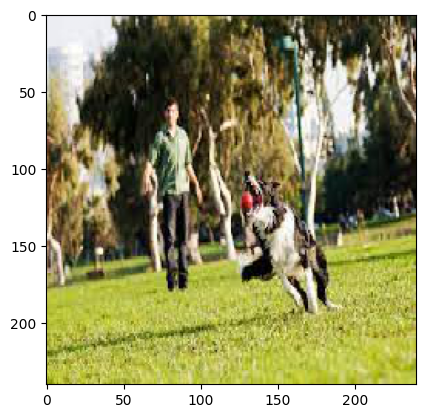

In [ ]:
img_path = "/content/Unknown.jpeg"
image = read_image(img_path)
plt.imshow(image)

In [ ]:
image = np.expand_dims(image, axis=0)
feature = cnn_model.predict(image, verbose=0)
y_pred = predict_caption(model, feature, tk, max_length)
print(y_pred)

1/1 [==============================] - 0s 45ms/step
startseq three dogs are running through the grass endseq


Using testing set

Actual : 
startseq an elderly person holds white doge and kisses their cheek endseq
startseq an old person is sitting in plush chair with huge white dog laying on top of him or her endseq
startseq an old woman is holding large white dog tightly while sitting in large red chair in front of some electronics endseq
startseq person is hugging big white dog and on red recliner endseq
startseq woman huge fluffy white dog endseq

Predicted : 
1/1 [==============================] - 0s 56ms/step
startseq two dogs are running through the grass endseq
Actual : 
startseq boy doing skateboard trick endseq
startseq skateboarder is balancing on wall while group of other boys watch endseq
startseq skateboarder on ramp doing trick endseq
startseq the boy is performing trick on skateboard endseq
startseq the skateboarder in the white shirt balances on the ledge as the others look on in the background endseq

Predicted : 
1/1 [==============================] - 0s 53ms/step
startseq man is doing trick on 

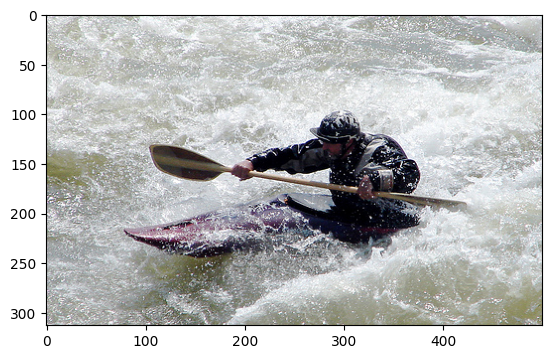

In [ ]:
draws = random.sample(range(len(test)), 15)
for draw in draws:
    image_id = str(test[draw])
    generate_caption(image_id)

Saving the tokenizer to a file

In [ ]:
import pickle
tokenizer_filename = '/content/drive/MyDrive/Colab Notebooks/flickr8k/tokenizer.pkl'
with open(tokenizer_filename, 'wb') as f:
    pickle.dump(tk, f)

###Conclusion :

I have made a model, that not completely accurate, generates a caption that is able to represent the image roughly